<a href="https://colab.research.google.com/github/jonaidsharif/Twitter-And-Reddit-Sentiment-Analysis/blob/main/Twitter_And_Reddit_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Impoting all the necessary library required
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,LSTM,GlobalMaxPooling1D,Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
import re,string,nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

# Reddit Dataset
df1 = pd.read_csv('/content/drive/MyDrive/Machine Learning/Twitter and Reddit Sentimental analysis Dataset/Reddit_Data.csv')
df1.head()

# Twitter Dataset
df2 = pd.read_csv('/content/drive/MyDrive/Machine Learning/Twitter and Reddit Sentimental analysis Dataset/Twitter_Data.csv')
df2.head()

In [ ]:
df1.head()

In [ ]:
#renaming the columns
df2.columns=['messages','labels']
df1.columns=['messages','labels']

In [ ]:
df1.head()

In [ ]:
df2.head()

## merging both the dataset

In [ ]:
df = pd.concat([df1, df2], ignore_index = True)

In [ ]:
df['messages'].iloc[0] #iloc is used to select a row

In [ ]:
df['messages'].iloc[100]

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df['length']=df['messages'].str.len()

In [ ]:
sns.set_style('whitegrid')
df['length'].plot(kind='hist',bins=100,)

In [ ]:
df.info()

In [ ]:
df.describe().transpose()

In [ ]:
#from the describe function we got to know that the longest message is of length 8665
df[df['length']==8665]['messages'].iloc[0]

In [ ]:
# mapping the labels to their respective meanings
df['labels']=df['labels'].map({-1:'negative',0:'neutral',1:'positive'})

In [ ]:
#checking the null values in the dataset
df.isnull().sum()

In [ ]:
#removing the null value witg dropna()
df=df.dropna()

In [ ]:
len(df['messages'])

In [ ]:
#cleaning the data from unnecessary data

#replacing url with string URL
def replace_url(text):
    return re.sub('https?:\/\/\S*|www\.\S+','URL',text)

#removing html
def remove_html(text):
    return re.sub('<.*?>','',text)

#replacing mentions with string user
def replace_mentions(text):
    return re.sub('@\S*','user',text,flags=re.IGNORECASE)

#replacing numbers with string number
def replace_num(text):
    return re.sub('^[+-]*?\d{1,3}[- ]*?\d{1,10}|\d{10}','NUMBER',text)

#replacing <3 with sring heart
def replace_heart(text):
    return re.sub('<3','HEART', text)

#removing alphanumeric characters eg-XYZ123ABC
def remove_alphanumeric(text):
    return re.sub('\w*\d+\w*','',text)

#removing all english stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

#removing punctuations
def remove_punctuations(text):
    text=''.join([word for word in text if word not in string.punctuation])
    return text

#reducing words to thier root form
def lemmatization(text):
    lm= WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text

In [ ]:
def clean_text(text):
    text=str(text).lower()
    text = replace_url(text)
    text = remove_html(text)
    text = replace_mentions(text)
    text = replace_num(text)
    text = replace_heart(text)
    text = remove_alphanumeric(text)
    text = remove_stopwords(text)
    text=remove_punctuations(text)
    #text=stemming(text)
    text=lemmatization(text)
    return text

In [ ]:
import nltk

# Try to find the wordnet data, if not found, download it.
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

# Import the WordNet corpus
from nltk.corpus import wordnet

# Assuming df is your dataframe, and 'messages' is the column you want to clean
# Define the clean_text function if not defined (for demonstration purposes)
def clean_text(text):
    # Add your text cleaning steps here (e.g., remove punctuation, lowercase, etc.)
    return text.lower()  # Simple lowercase for demonstration

# Apply clean_text function to the 'messages' column in the dataframe
df['messages1'] = df['messages'].apply(clean_text)

# Display the first few rows of the dataframe
df.head()

In [ ]:
df['messages1']

In [ ]:
#splitting the data for training and testing
X=df['messages1'].values
y = pd.get_dummies(df['labels']).values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)

In [ ]:
X_train.shape

In [ ]:
#converting the messages into tokens and then converting them into matrix of integers
Max_vocab_size=50000
tokenizer=Tokenizer(num_words=Max_vocab_size)
tokenizer.fit_on_texts(X_train)
sequence_Xtrain=tokenizer.texts_to_sequences(X_train)
sequence_Xtest=tokenizer.texts_to_sequences(X_test)

In [ ]:
V=len(tokenizer.word_index)

In [ ]:
tokenizer.word_index

In [ ]:
#padding the integer matrix with zero so that all the data have the same length
data_train=pad_sequences(sequence_Xtrain)

In [ ]:
T=data_train.shape[1]
print(T)

In [ ]:
data_test=pad_sequences(sequence_Xtest,maxlen=T)

In [ ]:
data_train.shape

In [37]:
data_test.shape

(66039, 1301)

In [38]:
D=20 #No of features you want
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)
i=Input(shape=(T,))
x=Embedding(V+1,D)(i)
x=LSTM(128,dropout=(0.2))(x)
x=Dense(3,activation='softmax')(x)
model=Model(i,x)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(data_train,y_train,batch_size=128,validation_data=(data_test,y_test),epochs=5,callbacks=[early_stop])

Epoch 1/5
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 4157s 4s/step - accuracy: 0.6191 - loss: 0.8819 - val_accuracy: 0.8082 - val_loss: 0.4952
Epoch 2/5
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 4108s 4s/step - accuracy: 0.8317 - loss: 0.4363 - val_accuracy: 0.9172 - val_loss: 0.2552
Epoch 3/5
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 4209s 4s/step - accuracy: 0.9325 - loss: 0.2074 - val_accuracy: 0.9444 - val_loss: 0.1823
Epoch 4/5
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 4294s 4s/step - accuracy: 0.9592 - loss: 0.1350 - val_accuracy: 0.9505 - val_loss: 0.1623
Epoch 5/5
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 4359s 4s/step - accuracy: 0.9625 - loss: 0.1266 - val_accuracy: 0.9530 - val_loss: 0.1558


In [39]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1301)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 1301, 20)            │       2,174,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          76,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,753,827 (25.76 MB)

 Trainable params: 2,251,275 (8.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,502,552 (17.18 MB)

In [40]:
#evaluating the model performance
model.evaluate(data_test,y_test)

2064/2064 ━━━━━━━━━━━━━━━━━━━━ 1174s 569ms/step - accuracy: 0.9525 - loss: 0.1581


[0.15580327808856964, 0.9529974460601807]

<Axes: >

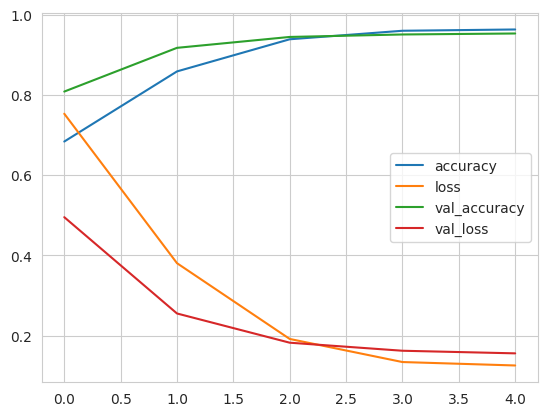

In [41]:
losses=pd.DataFrame(history.history)
losses.plot()

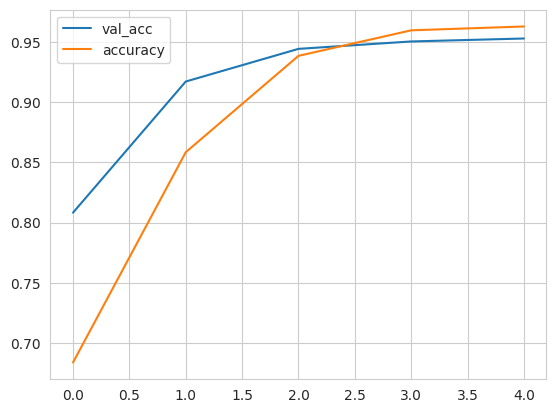

In [42]:
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.plot(history.history['accuracy'],label='accuracy')
plt.legend()

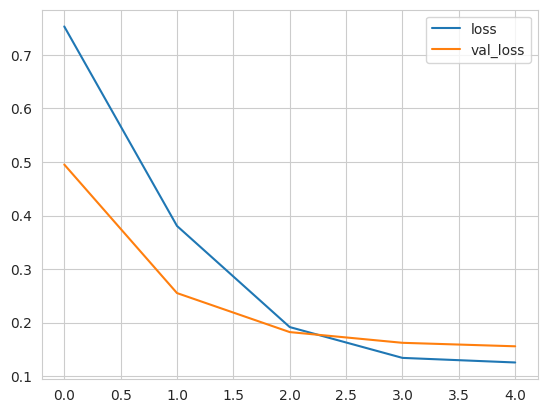

In [43]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()